In [1]:
import pandas as pd
import numpy as np

In [2]:
molecule_content_df = pd.read_feather('../data/local/molecule/full/content/1_processed.feather')
molecule_food_df = pd.read_feather('../data/local/molecule/full/food/1_processed.feather')
molecule_compound_df = pd.read_feather('../data/local/molecule/full/compound/0.feather')
recipe_ingredients_df = pd.read_feather('../data/local/recipe/partial/ingredients/0.feather')
recipe_df = pd.read_feather('../data/local/recipe/partial/recipe/0.feather')
ingredient_concentrations_df = pd.read_feather('../data/local/molecule/partial/compounds/0.feather')
weight_ratios_df = pd.read_feather('../data/local/density/partial/weights/0.feather')

In [3]:
ingredient_concentrations_df.shape, weight_ratios_df.shape

((2450, 1356), (2443, 1))

In [4]:
ingredient_concentrations_df = ingredient_concentrations_df.loc[weight_ratios_df.index]
weight_ratios_df = weight_ratios_df.loc[ingredient_concentrations_df.index]

# Dataset Format

Now we are at the stage of being able to join the data on its molecules and get the concentration of each element for each ingredient in the recipe.

How exactly would be best to format this?

### Strategy 

Lets start with the most simple dataset - only using the compounds for which we have given concentrations of. Before implementing this we can have a think how 'if present' information can be implemented as well.

### Requirements 

What do we need?

For each recipe, we want the concentraiton of each compound, found from the recipes ingredients & concentrations between these ingredients.

An additional detail here is that we need to be able to factor in modularity. We need to be able to add/remove/substitute ingredients according to what the model decides is an appropriate ingredient ratio composition.

# Implementing Format

So what do we currently have?

For each recipe:

- [x] ingredient weight
- [ ] ingredient weight concentration
- [x] ingredient molecule_db food_id
- [ ] ingredient compound concentration


# Relative Concentrations

Now that we have the weight concentrations of each compound (in mg/100g), as well as the weight concentration of each ingredient relative to the recipe. With this we can get the concentration of each compound in each *recipe*.

In [5]:
concentrations = ingredient_concentrations_df.to_numpy()
weight_ratios = weight_ratios_df.to_numpy()

In [6]:
concentrations.shape, weight_ratios.shape

((2443, 1356), (2443, 1))

In [7]:
relative_concentrations = concentrations * weight_ratios
relative_concentrations.shape

(2443, 1356)

In [8]:
relative_concentrations_df = pd.DataFrame(relative_concentrations, index=ingredient_concentrations_df.index, columns=ingredient_concentrations_df.columns)
relative_concentrations_df

source_id          12477 12664 236   316         446        474         484    \
recipe  ingredient                                                              
1746116 0            NaN   NaN   NaN   NaN    2.463923   4.942689    1.128061   
        1            NaN   NaN   NaN   NaN         0.0        0.0         0.0   
        2            NaN   NaN   NaN   NaN   28.724112  50.617598   23.987029   
        3            NaN   NaN   NaN   NaN         NaN        NaN         NaN   
        4            NaN   NaN   NaN   NaN         NaN        NaN         NaN   
...                  ...   ...   ...   ...         ...        ...         ...   
931097  9            NaN   NaN   NaN   NaN         NaN        NaN         NaN   
        10           NaN   NaN   NaN   NaN     2.48156   5.410244     3.94335   
        11           NaN   NaN   NaN   NaN         NaN        NaN         NaN   
        12           NaN   NaN   NaN   NaN  148.420674        NaN  261.828416   
        13           NaN   NaN   NaN   NaN         NaN        NaN         NaN   

source_id                556       565       567    ... 12675 12743 5439   \
recipe  ingredient                                  ...                     
1746116 0             1.810835  0.147242       NaN  ...   NaN   NaN   NaN   
        1                  0.0       0.0       NaN  ...   NaN   NaN   NaN   
        2            41.072464  0.073185       NaN  ...   NaN   NaN   NaN   
        3                  NaN       0.0       NaN  ...   NaN   NaN   NaN   
        4                  NaN       NaN       NaN  ...   NaN   NaN   NaN   
...                        ...       ...       ...  ...   ...   ...   ...   
931097  9                  NaN       NaN       NaN  ...   NaN   NaN   NaN   
        10            5.424134  0.301282  0.008536  ...   NaN   NaN   NaN   
        11           41.993836       NaN       NaN  ...   NaN   NaN   NaN   
        12          261.316032  0.063194       NaN  ...   NaN   NaN   NaN   
        13                 NaN  0.001877       NaN  ...   NaN   NaN   NaN   

source_id          12642 13828 234   20150 29802 9651  18378  
recipe  ingredient                                            
1746116 0            NaN   NaN   NaN   NaN   NaN   NaN   NaN  
        1            NaN   NaN   NaN   NaN   NaN   NaN   NaN  
        2            NaN   NaN   NaN   NaN   NaN   NaN   NaN  
        3            NaN   NaN   NaN   NaN   NaN   NaN   NaN  
        4            NaN   NaN   NaN   NaN   NaN   NaN   NaN  
...                  ...   ...   ...   ...   ...   ...   ...  
931097  9            NaN   NaN   NaN   NaN   NaN   NaN   NaN  
        10           NaN   NaN   NaN   NaN   NaN   NaN   NaN  
        11           NaN   NaN   NaN   NaN   NaN   NaN   NaN  
        12           NaN   NaN   NaN   NaN   NaN   NaN   NaN  
        13           NaN   NaN   NaN   NaN   NaN   NaN   NaN  

[2443 rows x 1356 columns]

In [9]:
(relative_concentrations_df > 1e3/1e-2).sum().sum()

0

# Formatting

The bulk of these requirements were done through finalising the molecule db in the previous chapter.

In [10]:
recipe_concentrations_df = relative_concentrations_df.groupby('recipe').sum()
recipe_concentrations_df

source_id,12477,12664,236,316,446,474,484,556,565,567,...,12675,12743,5439,12642,13828,234,20150,29802,9651,18378
recipe,,,,,,,,,,,,,,,,,,,,,
222,0,0,0.19611,0,58.192765,102.682204,43.024743,75.963291,0.439565,0,...,0,0,0,0,0,0,0,0,0,0
1703,0,0,0,0,255.877698,450.907394,213.679214,365.87824,0.65972,0,...,0,0,0,0,0,0,0,0,0,0
8981,0,0,0,0,113.871407,198.633316,95.674604,157.03695,0.479113,0,...,0,0,0,0,0,0,0,0,0,0
13596,0,0,0,0,97.825003,139.520463,93.495625,97.490144,2.390625,0,...,0,0,0,0,0,0,0,0,0,0
17929,0,0,0,0,38.65278,82.297216,69.65012,69.399496,0.444349,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2185822,0,0,0,0,60.607568,152.421109,149.942916,109.571041,0.76025,0.001767,...,0,0,0,0,0,0,0,0,0,0
2189489,0,0,0,0,131.327698,180.436174,272.600707,242.561525,2.736851,0,...,0,0,0,0,0,0,0,0,0,0
2195357,0,0,0,0,463.193012,1172.796966,600.897718,726.331033,0.229911,0,...,0,0,0,0,0,0,0,0,0,0


# Data Analysis

Now we can get to the fun part. Though it might also be the most difficult, as I don't know how this is going to work.

Ideas:

- Recipes with ingredient concentrations combined:
    - covariate matrix of all fields
    - values that are similar across recipes
    - different types of recipes (clustering)
    

## Clustering

In [11]:
import pandas as pd
from sklearn.cluster import KMeans

# Load your dataset into a pandas DataFpdrame
df = recipe_concentrations_df

# Select the columns containing the molecular compositions
X = df.iloc[:, 1:]

# Instantiate the KMeans class with the desired number of clusters
kmeans = KMeans(n_clusters=4)

# Fit the KMeans model to your data
kmeans.fit(X)

# Get the cluster labels for each data point
labels = kmeans.labels_

# Add the cluster labels to your original DataFrame
clusters = pd.Series(labels, index=df.index, name='cluster')

/home/steph/.conda/envs/recipes/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [12]:
# TODO: move this to 01-recipe prorocessing
recipe_df = recipe_df.loc[recipe_ingredients_df.index.get_level_values(0).unique()]
recipe_df.shape

(302, 6)

In [13]:
recipe_ingredients_df.join(clusters)

name.name                     name.description  quantity  \
recipe  ingredient                                                            
1746116 0                    butter              land lake butter     0.667   
        1                     sugar                         sugar       0.5   
        2                       egg                 land lake egg       2.0   
        3                   vanilla                       vanilla       1.0   
        4                     flour             all-purpose flour       1.5   
...                             ...                           ...       ...   
931097  9                 red onion                     red onion      0.25   
        10          red bell pepper               red bell pepper      0.25   
        11             jasmine rice                  jasmine rice       1.0   
        12                  chicken  reduced-sodium chicken broth       1.5   
        13              fresh basil                   fresh basil       1.0   

                          unit       comment     preparation  \
recipe  ingredient                                             
1746116 0                 cups          <NA>        softened   
        1                 cups          <NA>            <NA>   
        2                 <NA>  (yolks only)            <NA>   
        3             teaspoon          <NA>            <NA>   
        4                 cups          <NA>            <NA>   
...                        ...           ...             ...   
931097  9                 cups          <NA>  finely chopped   
        10                cups          <NA>         chopped   
        11                 cup          <NA>            <NA>   
        12                cups          <NA>            <NA>   
        13          tablespoon          <NA>         chopped   

                                          ingredient_string     unit_tags  \
recipe  ingredient                                                          
1746116 0             2/3 cup Land O Lakes Butter, softened         [cup]   
        1                                     1/2 cup sugar         [cup]   
        2                  2 Land O Lakes Eggs (yolks only)            []   
        3                                1 teaspoon vanilla    [teaspoon]   
        4                      1 1/2 cups all-purpose flour         [cup]   
...                                                     ...           ...   
931097  9                 1/4 cup red onion, finely chopped         [cup]   
        10                  1/4 cup chopped red bell pepper         [cup]   
        11                               1 cup Jasmine rice         [cup]   
        12          1 1/2 cups reduced-sodium chicken broth         [cup]   
        13                 1 tablespoon chopped fresh basil  [tablespoon]   

                   unit_remainders  cluster  
recipe  ingredient                           
1746116 0                       []      2.0  
        1                       []      2.0  
        2                       []      2.0  
        3                       []      2.0  
        4                       []      2.0  
...                            ...      ...  
931097  9                       []      0.0  
        10                      []      0.0  
        11                      []      0.0  
        12                      []      0.0  
        13                      []      0.0  

[2450 rows x 10 columns]

In [14]:
recipe_df[['title']].shape

(302, 1)

In [15]:
cluster_df = recipe_df[['title']].join(clusters).reset_index().set_index(['cluster', 'recipe']).sort_index()
cluster_df

title
cluster recipe                                                    
0.0     8981                                       Raised Bow Ties
        43845                Macaroni And Cottage Cheese Casserole
        64662                                         Surprise Pie
        92858                                     Sweet Potato Pie
        147316                                          Puppy Chow
...                                                            ...
3.0     2149994                                Stuffin' Egg Muffin
        2185822  Camarones A La Diabla Mexican Sauce - Mexican ...
        2195357                       Barbecued Fish Steaks Recipe
NaN     480397                                       Sausage Balls
        824709                                      Cinnamon Toast

[302 rows x 1 columns]

In [16]:
for cluster in cluster_df.index.get_level_values(0).unique():
    print(cluster, list(cluster_df['title'].loc[cluster]))

0.0 ['Raised Bow Ties', 'Macaroni And Cottage Cheese Casserole', 'Surprise Pie', 'Sweet Potato Pie', 'Puppy Chow', 'Valentine Cookies', 'Baked Chicken Breasts', 'Cheesy Potato Casserole', 'Baked Barbecue Hamburger Patties', 'Crunchy Parmesan Chicken', 'Potato Casserole', "Joey'S Favorite Oatmeal Cookies", 'Spiced Rubbed Hens', 'Layered Blackberry Dessert', 'Beef Stroganoff', 'Cheesy Potato Soup', 'Potato Casserole', 'Tangy Fruit Cocktail', 'Butter Apricot Cake', 'Patrician Potatoes', 'Chicken Salad', 'Chicken In Wine', 'Pumpkin Pie Cake', "Rhonda'S Broccoli Casserole", 'Butter Pecan Cookies', 'Broccoli Casserole', 'Popcorn Cake', 'Baked Purple Passion', 'Hibachi-Style Fried Rice', 'Pineapple Spiced Chicken And Rice', 'Creamy Acorn Squash', 'Southwest Tortellini Chowder', 'Ezekiel Bread Pizzas', 'Mushroom-Stuffed Beef Tenderloin', 'Champ-Icetini', 'Veal With Peas', 'Fish Fillets With Lemon And Caper Sauce', 'Melon And Grape Medley', 'Barbecued Tofu With Peppers And Onions', 'Maritime Bl

It looks like there is some sort of distinguishment between recipes (hearty savoury meals, dinners, baked savoury, desserts)

## Coveriate Matrix

In [17]:
import pandas as pd
import numpy as np
import seaborn as sns

import torch
from sklearn.metrics.pairwise import cosine_similarity

import json
from itertools import groupby
import re
import string

from tqdm import tqdm
tqdm.pandas()

from food_database.utils.utils import *

<Axes: >

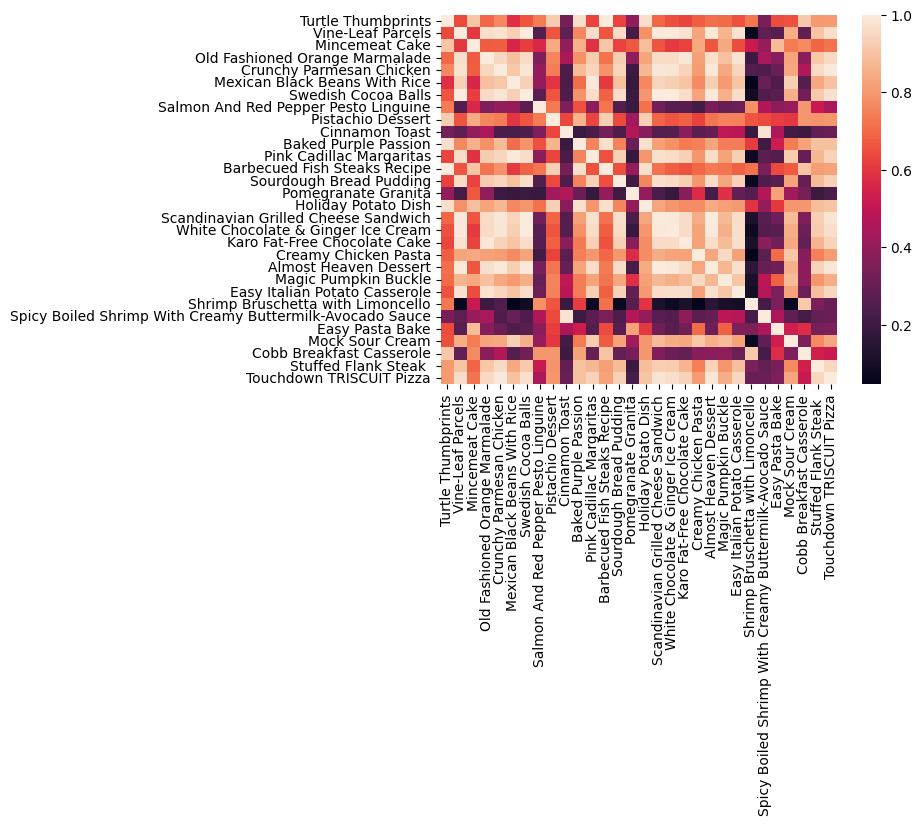

In [18]:
recipe_similarity_matrix = cosine_similarity(recipe_concentrations_df.head(30))
sns.heatmap(recipe_similarity_matrix, xticklabels=recipe_df['title'].head(30), yticklabels=recipe_df['title'].head(30))

Again we are seeing some resemblance of appropriate recognition of similarities though it's still clutching at straws.

Look at the centre of this board. We see pasta, casserole, cake, and icecream all giving very high similarities between one another.

## PCA

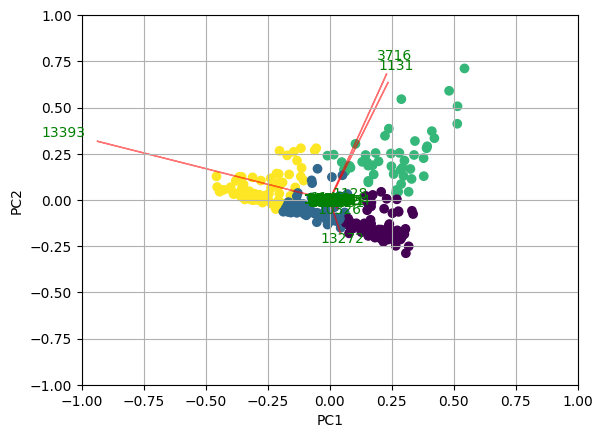

In [19]:
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

x = recipe_concentrations_df
y = clusters  

pca = PCA()
x_scaled = StandardScaler().fit_transform(x)
# x_new = pca.fit_transform(x_scaled)
x_pca = pca.fit_transform(x)

def myplot(score,coeff,labels=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    plt.scatter(xs * scalex,ys * scaley, c = y)
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
        if labels is None:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'g', ha = 'center', va = 'center')
        else:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.xlabel("PC{}".format(1))
plt.ylabel("PC{}".format(2))
plt.grid()

#Call the function. Use only the 2 PCs.
myplot(x_pca[:,0:2],np.transpose(pca.components_[0:2, :]), recipe_concentrations_df.columns)
plt.show()

In [20]:
molecule_compound_df.loc[[3716, 1131]]

,public_id,name,moldb_iupac,state,annotation_quality,description,cas_number,moldb_inchikey,moldb_inchi,moldb_smiles,moldb_mono_mass,kingdom,superklass,klass,subklass
id,,,,,,,,,,,,,,,
3716,FDB003715,Sugars,<NA>,low,"In chemistry, sugar loosely refers to a number...",57-50-1,OC[C@H]1O[C@@](CO)(O[C@H]2O[C@H](CO)[C@@H](O)[...,InChI=1S/C12H22O11/c13-1-4-6(16)8(18)9(19)11(2...,342.116212,CZMRCDWAGMRECN-UGDNZRGBSA-N,"(2R,3R,4S,5S,6R)-2-{[(2S,3S,4S,5R)-3,4-dihydro...",<NA>,<NA>,<NA>,<NA>
1131,FDB001131,Sucrose,Solid,low,Sweetening agent and food source assimilated b...,57-50-1,OCC1OC(CO)(OC2OC(CO)C(O)C(O)C2O)C(O)C1O,InChI=1S/C12H22O11/c13-1-4-6(16)8(18)9(19)11(2...,342.116212,CZMRCDWAGMRECN-UHFFFAOYSA-N,"2-{[3,4-dihydroxy-2,5-bis(hydroxymethyl)oxolan...",Organic compounds,Organooxygen compounds,Carbohydrates and carbohydrate conjugates,Glycosyl compounds


In [21]:
molecule_content_df[molecule_content_df.index.get_level_values(1).isin([13393, 3716, 1131])]['source_name'].unique()

<StringArray>
['Sucrose', 'Sugars', 'Moisture']
Length: 3, dtype: string

A couple things can be spotter here. 

1. The clusters can easily be shown from just the PCA components.
2. The most impactful features in explaining the variance here are sugar, and moisture.

So the best features here in distinguishing between recipes are sugar, and moisture.